0. 研究明白Currency Swap和Futures到底怎么用
1. 每【15天】重新设置一个新的standard_exchange_rate,而不是全程使用同一个standard_exchange_rate，此时【FREQUENCY = 15】这个HP就非常值得好好调一下
2. 学Optuna和https://wandb.ai/site/sweeps + 做Hyperparametres的tuning
3. 加一个杠杆率变量，然后限制只有在杠杆率满足某个要求时，才交易，否则为‘null’


## **1. Import**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
  # https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
  # https://towardsdatascience.com/explaining-the-settingwithcopywarning-in-pandas-ebc19d799d25
  
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 37.8 gigabytes of available RAM

You are using a high-RAM runtime!


## **2. Define Hyperparametres**

In [3]:
#FILE = "/content/drive/MyDrive/GBPUSD 20210902/GBPUSD_201109_202108.csv"

TRADING_START_DATE = pd.Timestamp(2018,10,1,0,0,0,0)
DAYS = 14
FREQUENCY = 14
DELTA_PERCENTAGE = 0

NUM_OF_LINES = 3

INITIAL_GBP_BALANCE = 5000 #此数字可任意调整


## **3. Prepare For Data**




In [4]:
df = pd.DataFrame()
for year in range(2018,2021):
  FILE = "/content/drive/MyDrive/GBPUSD_20210902/GBPUSD_" + str(year) + "09_" + str(year+1) + "08.csv"

  df_per = pd.read_csv(FILE)
  df = pd.concat([df,df_per], axis=0, ignore_index=True)


In [5]:
# https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html
# https://towardsdatascience.com/10-tricks-for-converting-numbers-and-strings-to-datetime-in-pandas-82a4645fc23d
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%Y%m%d %H:%M:%S:%f")


In [6]:
DAYS_TIMEDELTA = pd.Timedelta(DAYS,unit='days')
FREQUENCY_TIMEDELTA = pd.Timedelta(FREQUENCY,unit='days')

SUB_TRADING_START_DATES = pd.date_range(start=TRADING_START_DATE, end=df['Timestamp'].iloc[-1], freq=FREQUENCY_TIMEDELTA)

data_temp = df[df['Timestamp'] >= TRADING_START_DATE].iloc[0]
standard_exchange_rate = (data_temp['Bid price'] + data_temp['Ask price']) / 2

In [36]:
# CALCULATE THE TEN LINES
def get_ten_lines_and_dfAug(sub_trading_start_date):
  #df_Jul
  df_Jul = df[(df['Timestamp'] >= (sub_trading_start_date - DAYS_TIMEDELTA)) & (df['Timestamp'] < sub_trading_start_date)]
  df_Jul['mid_price'] = (df_Jul['Bid price'] + df_Jul['Ask price'])/2
  df_Jul['time_delta'] = (df_Jul['Timestamp'].shift(-1) - df_Jul['Timestamp'])
  
  mean_Jul = ((df_Jul['time_delta'] * df_Jul['mid_price']).sum()) / (df_Jul['Timestamp'].iloc[-1] - df_Jul['Timestamp'].iloc[0]) #此算法可以调整
  max_Jul_bid = df_Jul['Bid price'].max()
  min_Jul_ask = df_Jul['Ask price'].min()

  delta = (max_Jul_bid - min_Jul_ask) * DELTA_PERCENTAGE # 0这个数字可以调
  max_Jul_bid += delta
  min_Jul_ask -= delta

  sell_lines = np.arange(mean_Jul,max_Jul_bid+0.000001,(max_Jul_bid-mean_Jul)/NUM_OF_LINES) #sell_lines的生成方式可以调整
  buy_lines = np.arange(min_Jul_ask,mean_Jul,(mean_Jul-min_Jul_ask)/NUM_OF_LINES) #buy_lines的生成方式可以调整
  lines = np.concatenate((buy_lines,sell_lines))

  df_Aug = df[(df['Timestamp'] >= sub_trading_start_date) & (df['Timestamp'] < (sub_trading_start_date + FREQUENCY_TIMEDELTA))]
  df_Aug = df_Aug.reset_index(drop=True)

  return (lines, df_Aug)


## **4. Trading**

In [37]:
def trade(SUB_TRADING_START_DATES, increase_only=True):
  #Initialization for Trading
  trading_lines_history_status = []
  trading_prices_history_status = []
  trading_history_status = {}

  #Trading Process
  for s in SUB_TRADING_START_DATES:
    (lines, df_Aug) = get_ten_lines_and_dfAug(s)
    df_trading = df_Aug.copy()

    MID_PRICE_AT_INDEX_ZERO = (df_trading.iloc[0]['Ask price'] + df_trading.iloc[0]['Bid price']) / 2
    temp = list(lines > MID_PRICE_AT_INDEX_ZERO).count(False)
    current_two_lines_status = [temp-1, temp]
    latest_line_status = temp - 0.3

    while True:

      if (0 < latest_line_status < (len(lines)-1)):
        df_temp = df_trading[(df_trading['Ask price'] <= lines[current_two_lines_status[0]]) | (df_trading['Bid price'] >= lines[current_two_lines_status[1]])]
        if len(df_temp) == 0:
          break
        latest_trading_index_status = df_temp.iloc[0].name 

        if df_trading.loc[latest_trading_index_status]['Bid price'] >= lines[current_two_lines_status[1]]:
          latest_line_status = int(latest_line_status + 1) #这个操作主要是为了照顾到第1次交易时，latest_trading_index_status的初始状态是个小数（x.7）
          if increase_only == True:
            if (lines[current_two_lines_status[1]]) > standard_exchange_rate:
              trading_history_status[latest_trading_index_status] = 'sell'
            else:
              trading_history_status[latest_trading_index_status] = 'null'
          elif increase_only == False:
            trading_history_status[latest_trading_index_status] = 'sell'
        else:
          latest_line_status = round(latest_line_status - 1) #这个操作主要是为了照顾到第1次交易时，latest_trading_index_status的初始状态是个小数（x.7）
          if increase_only == True:
            if (lines[current_two_lines_status[0]]) < standard_exchange_rate:
              trading_history_status[latest_trading_index_status] = 'buy'
            else:
              trading_history_status[latest_trading_index_status] = 'null'
          elif increase_only == False:
            trading_history_status[latest_trading_index_status] = 'buy'

      elif latest_line_status >= (len(lines)-1):
        df_temp = df_trading[(df_trading['Ask price'] <= lines[-2])]
        if len(df_temp) == 0:
          break
        latest_trading_index_status = df_temp.iloc[0].name

        latest_line_status = len(lines) - 2

        if increase_only == True:
          if (lines[-2] < standard_exchange_rate):
            trading_history_status[latest_trading_index_status] = 'buy'
          else:
            trading_history_status[latest_trading_index_status] = 'null'
        elif increase_only == False:
          trading_history_status[latest_trading_index_status] = 'buy'

      elif latest_line_status <= 0:
        df_temp = df_trading[(df_trading['Bid price'] >= lines[1])]
        if len(df_temp) == 0:
          break
        latest_trading_index_status = df_temp.iloc[0].name

        latest_line_status = 1 

        if increase_only == True:
          if (lines[1] > standard_exchange_rate):
            trading_history_status[latest_trading_index_status] = 'sell'
          else:
            trading_history_status[latest_trading_index_status] = 'null'
        elif increase_only == False:
          trading_history_status[latest_trading_index_status] = 'sell'
      
      current_two_lines_status = [latest_line_status-1,latest_line_status+1]

      trading_lines_history_status.append(latest_line_status)
      trading_prices_history_status.append(lines[latest_line_status])

      df_trading = df_trading.loc[(latest_trading_index_status+1):]


  list_buy_sell_or_null = list(trading_history_status.values())

  print('Length of list_buy_sell_or_null: ', len(list_buy_sell_or_null))
  print('list_buy_sell_or_null: ', list_buy_sell_or_null)
  print('trading_prices_history_status: ', trading_prices_history_status)

  return (list_buy_sell_or_null, trading_prices_history_status)


In [9]:
(list_buy_sell_or_null, trading_prices_history_status) = trade(SUB_TRADING_START_DATES)

Length of list_buy_sell_or_null:  496
list_buy_sell_or_null:  ['sell', 'buy', 'sell', 'sell', 'null', 'sell', 'sell', 'null', 'sell', 'sell', 'null', 'null', 'null', 'buy', 'buy', 'null', 'null', 'null', 'sell', 'buy', 'buy', 'null', 'buy', 'null', 'buy', 'null', 'buy', 'buy', 'buy', 'null', 'buy', 'null', 'buy', 'buy', 'buy', 'null', 'null', 'buy', 'buy', 'null', 'buy', 'null', 'buy', 'null', 'null', 'null', 'buy', 'buy', 'buy', 'buy', 'buy', 'null', 'null', 'null', 'null', 'null', 'buy', 'null', 'buy', 'null', 'null', 'buy', 'null', 'null', 'buy', 'buy', 'buy', 'null', 'null', 'null', 'null', 'buy', 'buy', 'null', 'buy', 'buy', 'buy', 'null', 'null', 'sell', 'buy', 'sell', 'sell', 'sell', 'null', 'sell', 'null', 'null', 'buy', 'sell', 'sell', 'null', 'sell', 'sell', 'null', 'sell', 'null', 'null', 'sell', 'null', 'buy', 'sell', 'buy', 'sell', 'sell', 'null', 'buy', 'sell', 'buy', 'sell', 'sell', 'buy', 'buy', 'null', 'null', 'null', 'sell', 'buy', 'sell', 'sell', 'null', 'buy', 'buy'

## **5. Calculate the profit**

In [10]:
def calculate_profit():
  #Initialization for Calculating the Profit
  INVESTMENT_GBP_PER = INITIAL_GBP_BALANCE/NUM_OF_LINES

  INITIAL_USD_BALANCE = INITIAL_GBP_BALANCE * standard_exchange_rate

  TOTAL_COST_USD = INITIAL_GBP_BALANCE * standard_exchange_rate + INITIAL_USD_BALANCE
  TOTAL_COST_GBP = INITIAL_USD_BALANCE / standard_exchange_rate + INITIAL_GBP_BALANCE

  balance_usd_list = [INITIAL_USD_BALANCE]
  balance_gbp_list = [INITIAL_GBP_BALANCE]
  balance_equivalent_total_usd_list = [TOTAL_COST_USD]
  balance_equivalent_total_gbp_list = [TOTAL_COST_GBP]
  profit_rate_usd_list = [0]
  profit_rate_gbp_list = [0]

  #Calculating Process
  for i in range(len(list_buy_sell_or_null)):

    trading_price = trading_prices_history_status[i]
    
    if list_buy_sell_or_null[i] == 'buy':
      balance_usd = balance_usd_list[-1] - INVESTMENT_GBP_PER * trading_price
      balance_gbp = balance_gbp_list[-1] + INVESTMENT_GBP_PER
    elif list_buy_sell_or_null[i] == 'sell':
      balance_usd = balance_usd_list[-1] + INVESTMENT_GBP_PER * trading_price
      balance_gbp = balance_gbp_list[-1] - INVESTMENT_GBP_PER
    
    balance_equivalent_total_usd = balance_usd + balance_gbp * standard_exchange_rate
    balance_equivalent_total_gbp = balance_gbp + balance_usd / standard_exchange_rate

    profit_rate_usd = (balance_equivalent_total_usd - TOTAL_COST_USD) / TOTAL_COST_USD
    profit_rate_gbp = (balance_equivalent_total_gbp - TOTAL_COST_GBP) / TOTAL_COST_GBP

    balance_usd_list.append(balance_usd)
    balance_gbp_list.append(balance_gbp)

    balance_equivalent_total_usd_list.append(balance_equivalent_total_usd)
    balance_equivalent_total_gbp_list.append(balance_equivalent_total_gbp)

    profit_rate_usd_list.append(profit_rate_usd)
    profit_rate_gbp_list.append(profit_rate_gbp)

  balance_usd_list = np.array(balance_usd_list)
  balance_usd_list = np.round(balance_usd_list,2)
  balance_usd_list = list(balance_usd_list)
  balance_gbp_list = np.array(balance_gbp_list)
  balance_gbp_list = np.rint(balance_gbp_list)
  balance_gbp_list = list(balance_gbp_list)
  balance_equivalent_total_usd_list = np.array(balance_equivalent_total_usd_list)
  balance_equivalent_total_usd_list = np.round(balance_equivalent_total_usd_list,2)
  balance_equivalent_total_usd_list = list(balance_equivalent_total_usd_list)
  balance_equivalent_total_gbp_list = np.array(balance_equivalent_total_gbp_list)
  balance_equivalent_total_gbp_list = np.round(balance_equivalent_total_gbp_list,2)
  balance_equivalent_total_gbp_list = list(balance_equivalent_total_gbp_list)
  profit_rate_usd_list = np.array(profit_rate_usd_list)
  profit_rate_usd_list = np.round(profit_rate_usd_list,4)
  profit_rate_usd_list = list(profit_rate_usd_list)
  profit_rate_gbp_list = np.array(profit_rate_gbp_list)
  profit_rate_gbp_list = np.round(profit_rate_gbp_list,4)
  profit_rate_gbp_list = list(profit_rate_gbp_list)
    
  #最后一次交易之后的balance和profit（trading_price是最后一次交易的价格）
  #print('balance_usd_list: ',balance_usd_list)
  #print('balance_gbp_list: ',balance_gbp_list)
  #print('balance_equivalent_total_usd_list: ',balance_equivalent_total_usd_list)
  #print('balance_equivalent_total_gbp_list: ',balance_equivalent_total_gbp_list)
  #print('profit_rate_usd_list: ',profit_rate_usd_list)
  #print('profit_rate_gbp_list: ',profit_rate_gbp_list)

  return (balance_usd_list, balance_gbp_list, balance_equivalent_total_usd_list, profit_rate_usd_list)


profit_rate_usd_list:  [0.0, 0.0001, 0.0011, 0.0012, 0.0024, 0.0024, 0.0035, 0.0058, 0.0058, 0.0075, 0.01, 0.01, 0.01, 0.01, 0.0107, 0.0121, 0.0121, 0.0121, 0.0121, 0.013, 0.0131, 0.0146, 0.0146, 0.0161, 0.0161, 0.0177, 0.0177, 0.0185, 0.0206, 0.0238, 0.0238, 0.027, 0.027, 0.0302, 0.0336, 0.038, 0.038, 0.038, 0.0414, 0.0457, 0.0457, 0.05, 0.05, 0.0543, 0.0543, 0.0543, 0.0543, 0.0583, 0.063, 0.0685, 0.0748, 0.082, 0.082, 0.082, 0.082, 0.082, 0.082, 0.0859, 0.0859, 0.0899, 0.0899, 0.0899, 0.0932, 0.0932, 0.0932, 0.0961, 0.0997, 0.104, 0.104, 0.104, 0.104, 0.104, 0.1047, 0.1069, 0.1069, 0.1092, 0.1111, 0.1144, 0.1144, 0.1144, 0.1148, 0.1153, 0.1157, 0.1171, 0.1194, 0.1194, 0.1217, 0.1217, 0.1217, 0.1221, 0.1231, 0.1257, 0.1257, 0.1282, 0.1322, 0.1322, 0.1352, 0.1352, 0.1352, 0.137, 0.137, 0.1371, 0.138, 0.138, 0.1389, 0.1407, 0.1407, 0.1408, 0.1417, 0.1417, 0.1426, 0.1432, 0.1433, 0.1441, 0.1441, 0.1441, 0.1441, 0.1447, 0.1448, 0.1454, 0.1467, 0.1467, 0.1468, 0.1476, 0.1476, 0.1484, 0.148

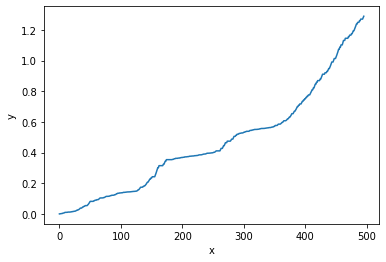

In [11]:
(balance_usd_list, balance_gbp_list, balance_equivalent_total_usd_list, profit_rate_usd_list) = calculate_profit()
final_profit_rate_usd = profit_rate_usd_list[-1]


print('profit_rate_usd_list: ', profit_rate_usd_list)
print('final_profit_rate_usd: ', final_profit_rate_usd)
print('max_profit_rate_usd: ', max(profit_rate_usd_list))
print('min_profit_rate_usd: ', min(profit_rate_usd_list))

df_result_plot = pd.DataFrame({'x':range(len(list_buy_sell_or_null)), 'y':profit_rate_usd_list[1:]})
sns.lineplot(x='x', y='y', data=df_result_plot)


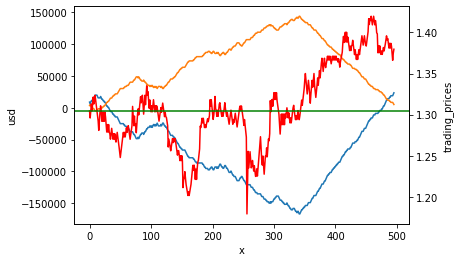

In [32]:
# https://stackoverflow.com/questions/58785983/seaborn-plot-with-shared-x-axis

df_hahaha = pd.DataFrame({'x':range(len(list_buy_sell_or_null)), 'usd':balance_usd_list[1:], 'gbp':balance_gbp_list[1:], 'trading_prices':trading_prices_history_status})

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

sns.lineplot(x='x', y='usd', data=df_hahaha, ax=ax1)
sns.lineplot(x='x', y='gbp', data=df_hahaha, ax=ax1)
sns.lineplot(x='x', y='trading_prices', data=df_hahaha, ax=ax2, color='red')
plt.axhline(standard_exchange_rate, color='green')

In [35]:
pd.value_counts(list_buy_sell_or_null)

null    228
sell    134
buy     134
dtype: int64